## DEMO

- Load CSV
- Data Validation & preprocessing
- EDA + Visulaization
- Bias Detection (data bias + prediction bias)
- Mitigation: Reweighting, Oversampling, Threshold Optimization
- Before and After Comparison
- Save dataset + retrained model 

### 1. Configuration

In [1]:
CSV_PATH = "adult.csv"
TARGET_COL = "income"
SENSITIVE_COL = "gender"
SAVE_DIR = "outputs"

TEST_SIZE = 0.3
RANDOM_STATE = 42

### 2. Imports

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

try:
    from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
    from fairlearn.postprocessing import ThresholdOptimizer
    from fairlearn.reductions import ExponentiatedGradient, DemographicParity
except Exception as e:
    print("Warning: fairlearn not available:", e)
    
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    print("Warning: imbalanced-learn not available:", e)
    
os.makedirs(SAVE_DIR, exist_ok=True)

def _div(title=None):
    print("\n" + ("="*8) + (f" {title} " if title else "") + ("="*8))

### 3. Load Dataset

In [3]:
_div("Load data")
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

_div("Missing values summary")
print(df.isna().sum().sort_values(ascending=False).head(20))

_div("Duplicate rows")
print("Duplicate rows:", df.duplicated().sum())


======== Load data ========
Shape: (48842, 15)
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

======== Missing values summary ========
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

======== Duplicate rows ========
Duplicate rows: 52


In [4]:
df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
5955,20,Private,186014,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,38,United-States,<=50K
33187,32,Private,286689,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,42,United-States,>50K
8507,50,Self-emp-not-inc,200618,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
17830,27,Private,148069,10th,6,Never-married,Machine-op-inspct,Unmarried,White,Female,0,0,40,United-States,<=50K
35511,35,?,98989,9th,5,Divorced,?,Own-child,Amer-Indian-Eskimo,Male,0,0,38,United-States,<=50K


### 4. Basic EDA + Visualization

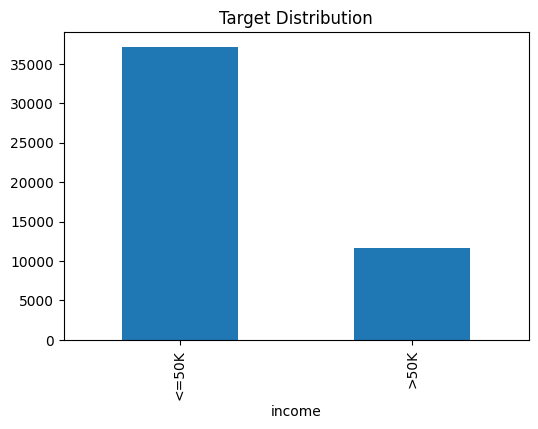

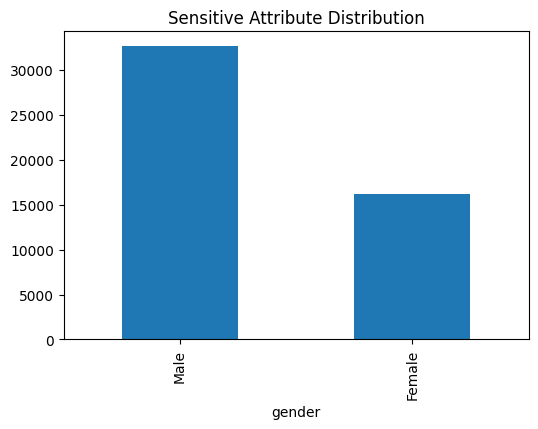

In [5]:
plt.figure(figsize=(6,4))
df[TARGET_COL].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.show()

plt.figure(figsize=(6,4))
df[SENSITIVE_COL].value_counts().plot(kind="bar")
plt.title("Sensitive Attribute Distribution")
plt.show()

### 5. Preprocessing

In [6]:
def preprocess(df, target, sensitive):
    df = df.copy()
    
    # impute missing
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
            
    # encode target
    if df[target].dtype == 'object':
        df[target] = LabelEncoder().fit_transform(df[target])
        
    # save sensitive before encoding
    sensitive_series = df[sensitive]
    
    # one-hot encode all categorical except sensitive
    df_encoded = pd.get_dummies(df.drop(columns=[sensitive]), drop_first=True)
    
    return df_encoded, df[target], sensitive_series, df

In [7]:
X, y, sensitive, df_clean = preprocess(df, TARGET_COL, SENSITIVE_COL)

print("Processed X: ", X.shape)
print("Processed X: ", y.shape)

Processed X:  (48842, 100)
Processed X:  (48842,)


### 6. Train Test Split

In [ ]:
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size = TEST_SIZE, stratify=y, random_state = RANDOM_STATE
)


In [9]:
X_train.shape, X_test.shape

((34189, 100), (14653, 100))

In [10]:
y_train.shape, y_test.shape

((34189,), (14653,))

### 7. Visualization: Sensitive Attribute Distribution (Train)

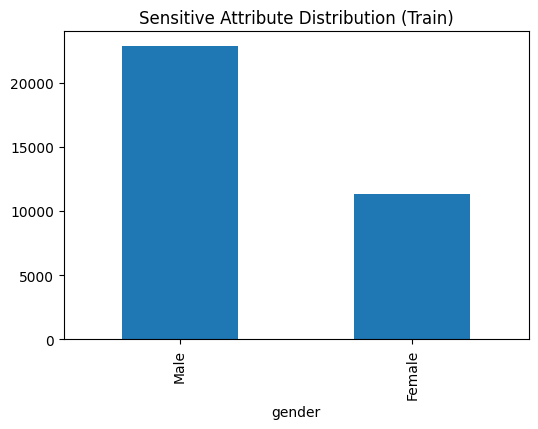

In [11]:
plt.figure(figsize=(6,4))
s_train.value_counts().plot(kind="bar")
plt.title("Sensitive Attribute Distribution (Train)")
plt.show()

### 8. Baseline Model - Logistic Regression

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline = LogisticRegression(max_iter=1000)
baseline.fit(X_train_scaled, y_train)
y_pred_base = baseline.predict(X_test_scaled)

### 9. Baseline Metrics + Fairness Evaluation

In [13]:
def fairness_eval(y_true, y_pred, sensitive):
    mf = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )
    
    dpd = demographic_parity_difference(y_true,  y_pred, sensitive_features=sensitive)
    return mf.by_group, dpd

group_metrics_base, dpd_base = fairness_eval(y_test, y_pred_base, s_test)

print("=== Baseline Group Metrics ===")
print(group_metrics_base)
print("\nDPD:", dpd_base)

=== Baseline Group Metrics ===
        accuracy  selection_rate
gender                          
Female       1.0        0.113856
Male         1.0        0.301450

DPD: 0.18759328136269376


### 10. Visualization: Baseline Selection Rate by Group

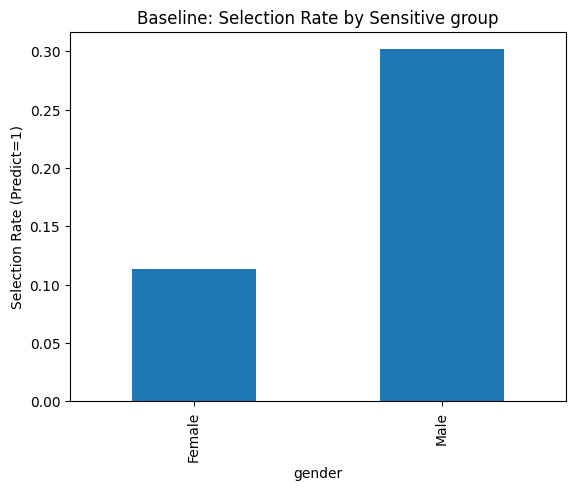

In [14]:
group_metrics_base["selection_rate"].plot(kind="bar")
plt.title("Baseline: Selection Rate by Sensitive group")
plt.ylabel("Selection Rate (Predict=1)")
plt.show()

### 11. Mitigation 1 - Reweighting (ExponentiatedGradient)

In [15]:
constraint = DemographicParity()

eg = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000),
    constraints = constraint
)

eg.fit(X_train_scaled, y_train, sensitive_features=s_train)
y_pred_reweight = eg.predict(X_test_scaled)

group_metrics_reweight, dpd_reweight = fairness_eval(y_test, y_pred_reweight, s_test)

#### Visualization: Reweighting Fairness Comparison

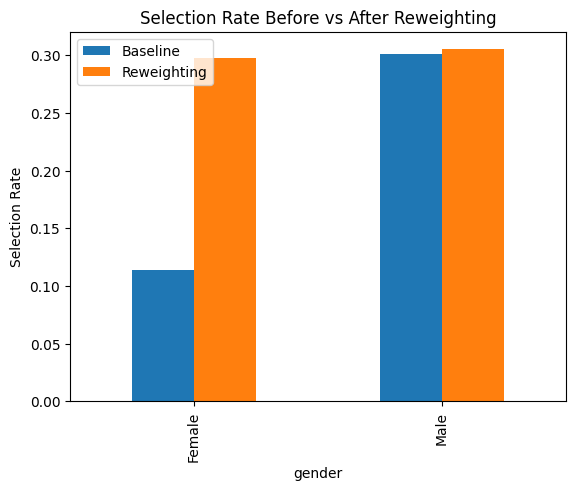

In [16]:
metrics_df = pd.DataFrame({
    "Baseline": group_metrics_base["selection_rate"],
    "Reweighting": group_metrics_reweight["selection_rate"]
})

metrics_df.plot(kind="bar")
plt.title("Selection Rate Before vs After Reweighting")
plt.ylabel("Selection Rate")
plt.show()

### 12. Mitigation 2 - Oversampling (SMOTE)

In [17]:
sm = SMOTE(random_state=RANDOM_STATE)

X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

oversample_clf = LogisticRegression(max_iter=1000)
oversample_clf.fit(X_res, y_res)

y_pred_over = oversample_clf.predict(X_test_scaled)

group_metrics_over, dpd_over = fairness_eval(y_test, y_pred_over, s_test)

### 13. Mitigation 3 - Threshold Optimization

In [18]:
thresh = ThresholdOptimizer(
    estimator=baseline,
    constraints="demographic_parity",
    prefit=True
)

thresh.fit(X_train_scaled, y_train, sensitive_features=s_train)
y_pred_thresh = thresh.predict(X_test_scaled, sensitive_features=s_test)

group_metrics_thresh, dpd_thresh = fairness_eval(y_test, y_pred_thresh, s_test)

### 14. Visualization: Compare All Methods

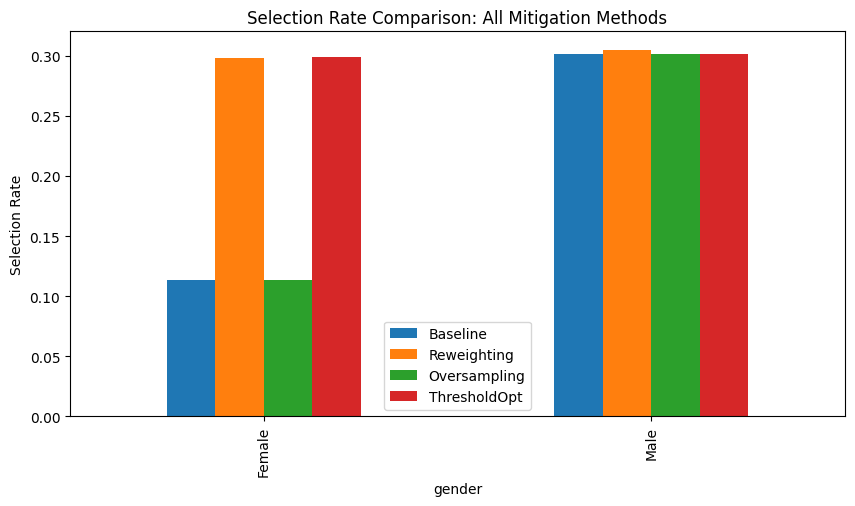

In [19]:
compare_df = pd.DataFrame({
    "Baseline": group_metrics_base["selection_rate"],
    "Reweighting": group_metrics_reweight["selection_rate"],
    "Oversampling": group_metrics_over["selection_rate"],
    "ThresholdOpt": group_metrics_thresh["selection_rate"]
})

compare_df.plot(kind="bar", figsize=(10,5))
plt.title("Selection Rate Comparison: All Mitigation Methods")
plt.ylabel("Selection Rate")
plt.show()

### 15. Confusion Matrix Visualization (Before vs After)

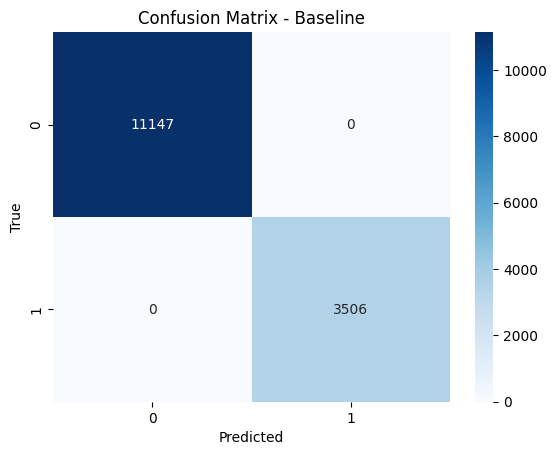

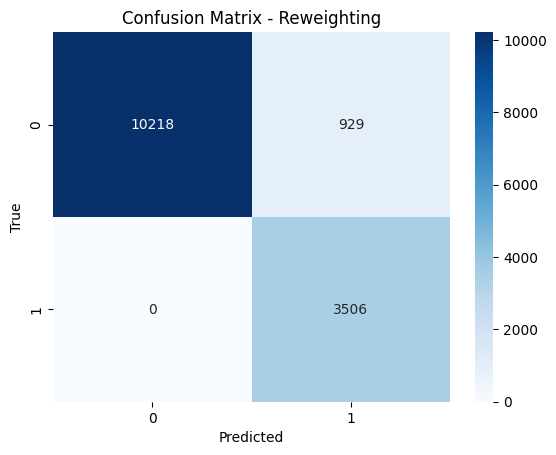

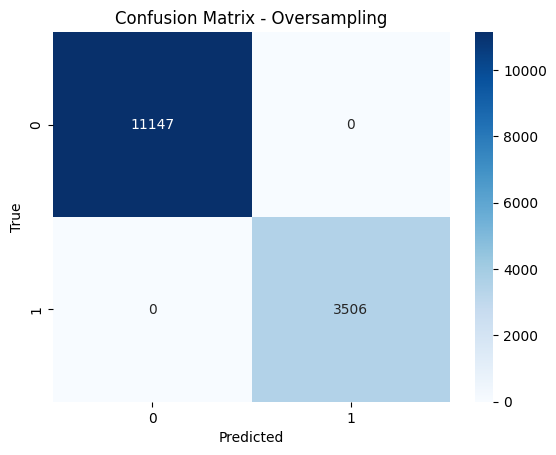

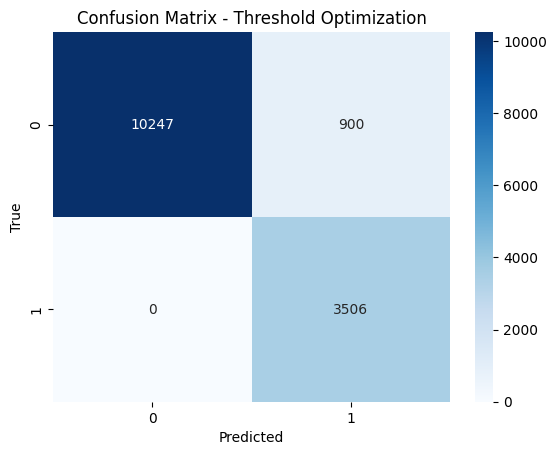

In [20]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
plot_cm(y_test, y_pred_base, "Confusion Matrix - Baseline")
plot_cm(y_test, y_pred_reweight, "Confusion Matrix - Reweighting")
plot_cm(y_test, y_pred_over, "Confusion Matrix - Oversampling")
plot_cm(y_test, y_pred_thresh, "Confusion Matrix - Threshold Optimization")

### 16. Save Debiased CSV and Model

In [55]:
joblib.dump(eg, os.path.join(SAVE_DIR, "model_reweighted.pkl"))
joblib.dump(oversample_clf, os.path.join(SAVE_DIR, "model_oversampled.pkl"))
joblib.dump(thresh, os.path.join(SAVE_DIR, "model_threshold.pkl"))

print("Artifacts saved in: ", SAVE_DIR)

Artifacts saved in:  outputs


### 17. Observation Summary

In [21]:
print("\n=== DPD Summary ===")
print("Baseline:", dpd_base)
print("Reweighting:", dpd_reweight)
print("Oversampling:", dpd_over)
print("Threshold Optimization:", dpd_thresh)

print("\nLower DPD = Less Bias.\n")


=== DPD Summary ===
Baseline: 0.18759328136269376
Reweighting: 0.0071019310718564155
Oversampling: 0.18759328136269376
Threshold Optimization: 0.0029096555106086774

Lower DPD = Less Bias.



In [ ]:
from sklearn.metrics import accuracy_score

acc_base = accuracy_score(y_test, y_pred_base)
acc_reweight = accuracy_score(y_test, y_pred_reweight)
acc_over = accuracy_score(y_test, y_pred_over)
acc_thresh = accuracy_score(y_test, y_pred_thresh)

print("Model Accuracy Comparison:\n")
print(f"Baseline Model Accuracy:            {acc_base:.4f}")
print(f"Reweighting Model Accuracy:         {acc_reweight:.4f}")
print(f"Oversampling Model Accuracy:        {acc_over:.4f}")
print(f"Threshold Optimization Accuracy:    {acc_thresh:.4f}")


Model Accuracy Comparison:

Baseline Model Accuracy:            1.0000
Reweighting Model Accuracy:         0.9366
Oversampling Model Accuracy:        1.0000
Threshold Optimization Accuracy:    0.9386
